# Capstone project: predict Rossmann's store sales

## Manuel Freude, May 2018

## Sales prediction code

Report and library sheets will be provided separately

### Exploratory data analysis

In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib as plt
%matplotlib inline

data = pd.read_csv('cleaned_dataset.csv')
data.drop(columns=['Unnamed: 0'] , inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 46 columns):
Store_ID                     1017209 non-null int64
Customers                    1017209 non-null int64
Sales                        1017209 non-null int64
Open                         1017209 non-null int64
H_None                       1017209 non-null int64
H_Public                     1017209 non-null int64
H_Easter                     1017209 non-null int64
H_X-Mas                      1017209 non-null int64
SchoolHoliday                1017209 non-null int64
Type_A                       1017209 non-null int64
Type_B                       1017209 non-null int64
Type_C                       1017209 non-null int64
Type_D                       1017209 non-null int64
Asort_Basic                  1017209 non-null int64
Asort_Extra                  1017209 non-null int64
Asort_Extended               1017209 non-null int64
Promo1                       1017209 non-null int64
Pro

In [108]:
data.head()

,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,Type_A,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,555,5263,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,546,5020,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,523,4782,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,560,5011,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,612,6102,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


There are many dummy variables in the dataset, but also numerical ones. For the numerical ones, I need to check if they are rather normally distributed so that they fit the regression approach. I will do this with the following ones: 
- Customers
- Sales
- DayOfMonth
- DayOfWeek
- Month
- Year

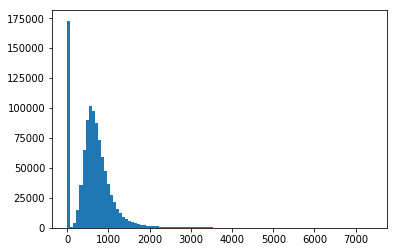

In [109]:
# plotting customers

pyplot.hist(data['Customers'], bins=100);

In [110]:
# checkig on the lower outlier

# source: https://stackoverflow.com/questions/35364601/group-by-and-find-top-n-value-counts-pandas

data['Customers'].value_counts().nlargest(5)

0      172869
560      2414
576      2363
603      2337
571      2330
Name: Customers, dtype: int64

This looks rather normally distributed. There are abnormalities where the customer number is zero. This might either indicated that the shop was not visited at all that day or it was a holiday etc., in that case I would expect the sales numbers to also be zero in many cases. 

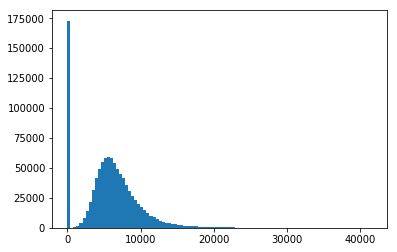

In [111]:
# plotting sales

pyplot.hist(data['Sales'], bins=100);

In [112]:
# checkig on the lower outlier

data['Sales'].value_counts().nlargest(5)

0       172871
5674       215
5558       197
5483       196
6049       195
Name: Sales, dtype: int64

Similar to customers, the data looks rather normally distributed except for the zero. The number of zeros is very high and almost the same as for the customers number. It might make sense to later on take a subset of the data to exclude the zeros and check how the regressions perform. The holidays will loose their relevancy in that case.

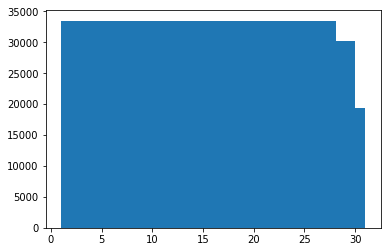

In [113]:
# plotting day of month

pyplot.hist(data['DayOfMonth'], bins=31);

Days of month look well-distributed. I was testing if there are any ones really low, but that's not the case. After 28, they decrease due to February usually not having more than 28 days and many months not having 31 days.

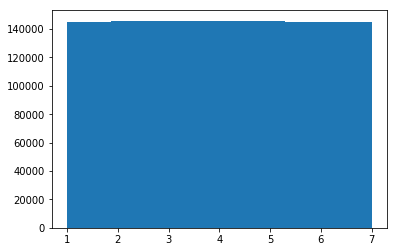

In [114]:
# plotting day of week

pyplot.hist(data['DayOfWeek'], bins=7);

In [115]:
# checking some numbers

data['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

Sundays are also included, might be days with low sales because shops would be closed most of the time.

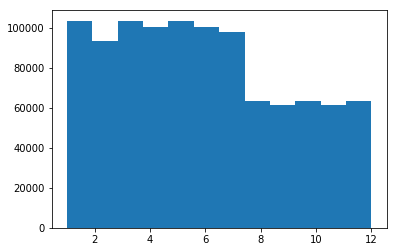

In [116]:
# plotting month

pyplot.hist(data['Month'], bins=12);

In [117]:
# checking some numbers

data['Month'].value_counts()

5     103695
3     103695
1     103694
6     100350
4     100350
7      98115
2      93660
12     63550
10     63550
8      63550
11     61500
9      61500
Name: Month, dtype: int64

All months are included. The second half of the year a little less, due to the structure of the provided data, which is not covering full years 2013 through 2015.

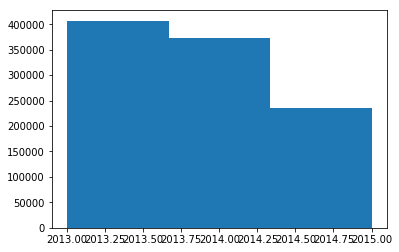

In [118]:
# plotting year

pyplot.hist(data['Year'], bins=3);

In [119]:
# checking some numbers

data['Year'].value_counts()

2013    406974
2014    373855
2015    236380
Name: Year, dtype: int64

Here we can see that we have less data for 2015, as guessed above. So overall, the data looks good for analysis. Next step is to split the dataset into train, test and true set. 

#### Multiple instance time series split

In [120]:
# making sure we sort the dataset by date to set ground for time series split

data.sort_values('Date', inplace=True);

data.head()

,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,Type_A,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1017208,1115,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
679363,746,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
155193,171,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
632403,694,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
361623,396,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [121]:
data['Date'].head(10)

1017208    2013-01-01
679363     2013-01-01
155193     2013-01-01
632403     2013-01-01
361623     2013-01-01
177271     2013-01-01
246633     2013-01-01
29407      2013-01-01
401231     2013-01-01
994762     2013-01-01
Name: Date, dtype: object

In [122]:
data['Date'].tail(10)

812458    2015-07-31
559230    2015-07-31
886552    2015-07-31
94082     2015-07-31
558288    2015-07-31
557530    2015-07-31
212332    2015-07-31
982701    2015-07-31
769288    2015-07-31
0         2015-07-31
Name: Date, dtype: object

In [123]:
# source: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

train_size = int(len(data['Date']) * 0.60)
test_size = int(len(data['Date']) * 0.80)
train, test, true = data[0:train_size], data[train_size:test_size], data[test_size:len(data['Date'])]
print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
print('"True" Observations: %d' % (len(true)))

Observations: 1017209
Training Observations: 610325
Testing Observations: 203442
"True" Observations: 203442


In [124]:
# comparing heads and info to make sure worked properly (train)

train.head()

,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,Type_A,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1017208,1115,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
679363,746,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
155193,171,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
632403,694,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
361623,396,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [125]:
# comparing heads and info to make sure worked properly (train)

train['Date'].head()

1017208    2013-01-01
679363     2013-01-01
155193     2013-01-01
632403     2013-01-01
361623     2013-01-01
Name: Date, dtype: object

In [186]:
# comparing heads and info to make sure worked properly (train)

train['Date'].tail()

331300     2014-07-02
759504     2014-07-02
680700     2014-07-02
113706     2014-07-02
1008551    2014-07-02
Name: Date, dtype: object

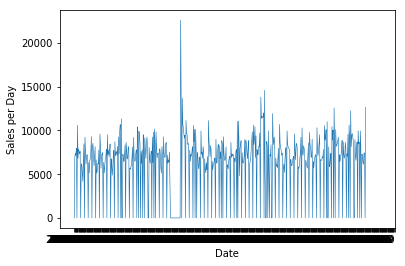

In [177]:
# plotting early 60% of sales per day for selected shop

x = train.loc[train['Store_ID'] == 100]
x = x['Date']
y = train.loc[train['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.xticks(np.arange(0, 600, step=1))
pyplot.show;

In [127]:
# comparing heads and info to make sure worked properly (train)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610325 entries, 1017208 to 1008551
Data columns (total 46 columns):
Store_ID                     610325 non-null int64
Customers                    610325 non-null int64
Sales                        610325 non-null int64
Open                         610325 non-null int64
H_None                       610325 non-null int64
H_Public                     610325 non-null int64
H_Easter                     610325 non-null int64
H_X-Mas                      610325 non-null int64
SchoolHoliday                610325 non-null int64
Type_A                       610325 non-null int64
Type_B                       610325 non-null int64
Type_C                       610325 non-null int64
Type_D                       610325 non-null int64
Asort_Basic                  610325 non-null int64
Asort_Extra                  610325 non-null int64
Asort_Extended               610325 non-null int64
Promo1                       610325 non-null int64
Promo2         

In [128]:
# comparing heads to make sure worked properly (test)

test.head()

,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,Type_A,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
582828,640,1017,15005,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
464026,509,537,6780,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
755736,830,629,6392,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
923337,1013,540,5369,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
516822,567,818,6743,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [129]:
# comparing heads and info to make sure worked properly (test)

test['Date'].head()

582828    2014-07-02
464026    2014-07-02
755736    2014-07-02
923337    2014-07-02
516822    2014-07-02
Name: Date, dtype: object

In [185]:
# comparing heads and info to make sure worked properly (test)

test['Date'].tail()

927835    2015-01-30
211572    2015-01-30
55804     2015-01-30
121420    2015-01-30
123304    2015-01-30
Name: Date, dtype: object

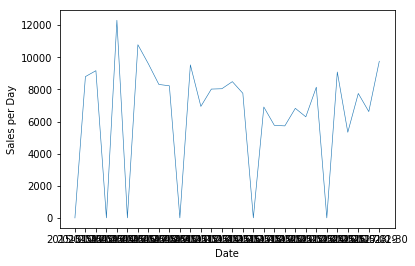

In [182]:
# plotting upper 60-80% of sales per day for selected shop

x = test.loc[test['Store_ID'] == 100]
x = x['Date']
y = test.loc[test['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.show;

In [130]:
# comparing heads to make sure worked properly (test)

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203442 entries, 582828 to 123304
Data columns (total 46 columns):
Store_ID                     203442 non-null int64
Customers                    203442 non-null int64
Sales                        203442 non-null int64
Open                         203442 non-null int64
H_None                       203442 non-null int64
H_Public                     203442 non-null int64
H_Easter                     203442 non-null int64
H_X-Mas                      203442 non-null int64
SchoolHoliday                203442 non-null int64
Type_A                       203442 non-null int64
Type_B                       203442 non-null int64
Type_C                       203442 non-null int64
Type_D                       203442 non-null int64
Asort_Basic                  203442 non-null int64
Asort_Extra                  203442 non-null int64
Asort_Extended               203442 non-null int64
Promo1                       203442 non-null int64
Promo2           

In [78]:
# comparing heads to make sure worked properly (true)

true.head()

,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,Type_A,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
708012,778,734,5628,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
334672,368,964,16270,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
579400,636,839,7895,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138214,153,542,6348,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
480034,527,1095,13630,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# comparing heads to make sure worked properly (true)

true['Date'].head()

708012    2015-01-30
334672    2015-01-30
579400    2015-01-30
138214    2015-01-30
480034    2015-01-30
Name: Date, dtype: object

In [184]:
# comparing heads to make sure worked properly (true)

true['Date'].tail()

557530    2015-07-31
212332    2015-07-31
982701    2015-07-31
769288    2015-07-31
0         2015-07-31
Name: Date, dtype: object

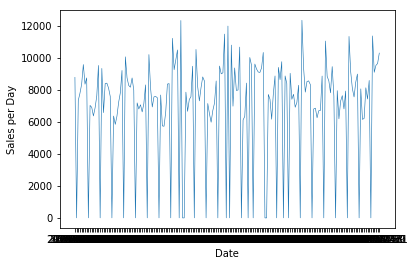

In [183]:
# plotting upper 20% of sales per day for selected shop

x = true.loc[true['Store_ID'] == 100]
x = x['Date']
y = true.loc[true['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.show;

In [80]:
# comparing heads to make sure worked properly (true)

true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203442 entries, 708012 to 0
Data columns (total 46 columns):
Store_ID                     203442 non-null int64
Customers                    203442 non-null int64
Sales                        203442 non-null int64
Open                         203442 non-null int64
H_None                       203442 non-null int64
H_Public                     203442 non-null int64
H_Easter                     203442 non-null int64
H_X-Mas                      203442 non-null int64
SchoolHoliday                203442 non-null int64
Type_A                       203442 non-null int64
Type_B                       203442 non-null int64
Type_C                       203442 non-null int64
Type_D                       203442 non-null int64
Asort_Basic                  203442 non-null int64
Asort_Extra                  203442 non-null int64
Asort_Extended               203442 non-null int64
Promo1                       203442 non-null int64
Promo2                